# 06.1a: Degenerate Cluster Analysis

**Goal:** Map the degenerate embedding singularity discovered at token 149415.

Token 149415 (Hebrew 'נּ') has nearest neighbors at **distance 0.000000** in both Euclidean and angular metrics. This suggests multiple token IDs mapped to identical (or numerically indistinguishable) embeddings during training.

We'll:
1. Count all tokens within epsilon of the reference token
2. Decode and categorize the degenerate tokens
3. Analyze the distribution of token IDs
4. Check if this is true degeneracy or numerical precision collapse

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Reference token (center of degenerate cluster)
REFERENCE_TOKEN_ID = 149415

# Distance threshold (gamma units)
EPSILON = 0.000001

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter
import unicodedata

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load γ' (centered embeddings)
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

N, d = gamma_prime.shape

print(f"Loaded γ' (centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loaded γ' (centered):
  Tokens: 151,936
  Dimensions: 2,560

Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507...


Tokenizer loaded.


## Step 2: Find All Tokens Within Epsilon

In [4]:
print(f"\nSearching for tokens within {EPSILON:.6f} gamma units of token {REFERENCE_TOKEN_ID}...\n")

# Get reference embedding
reference_embedding = gamma_prime[REFERENCE_TOKEN_ID]

# Compute Euclidean distances
distances = torch.norm(gamma_prime - reference_embedding, dim=1)

# Find tokens within epsilon (excluding reference itself)
within_epsilon = (distances <= EPSILON) & (torch.arange(N) != REFERENCE_TOKEN_ID)
n_degenerate = within_epsilon.sum().item()

print(f"Found {n_degenerate:,} tokens within epsilon (excluding reference)")
print(f"Including reference: {n_degenerate + 1:,} tokens total")
print(f"Percentage of vocabulary: {(n_degenerate + 1)/N*100:.4f}%")
print()

# Get their indices and distances
degenerate_indices = torch.where(within_epsilon)[0]
degenerate_distances = distances[degenerate_indices]

print(f"Distance statistics for degenerate tokens:")
print(f"  Min: {degenerate_distances.min().item():.12f}")
print(f"  Max: {degenerate_distances.max().item():.12f}")
print(f"  Mean: {degenerate_distances.mean().item():.12f}")
print(f"  Median: {degenerate_distances.median().item():.12f}")


Searching for tokens within 0.000001 gamma units of token 149415...

Found 833 tokens within epsilon (excluding reference)
Including reference: 834 tokens total
Percentage of vocabulary: 0.5489%

Distance statistics for degenerate tokens:
  Min: 0.000000000000
  Max: 0.000000903888
  Mean: 0.000000003188
  Median: 0.000000000000


## Step 3: Decode All Degenerate Tokens

In [5]:
print("\n" + "="*60)
print("DEGENERATE TOKENS")
print("="*60)
print()

# Include reference token
all_degenerate_indices = torch.cat([torch.tensor([REFERENCE_TOKEN_ID]), degenerate_indices])
all_degenerate_distances = torch.cat([torch.tensor([0.0]), degenerate_distances])

# Sort by distance
sorted_indices = torch.argsort(all_degenerate_distances)

# Build table
results = []
for rank, idx in enumerate(sorted_indices, 1):
    token_id = all_degenerate_indices[idx].item()
    distance = all_degenerate_distances[idx].item()
    token_str = tokenizer.decode([token_id])
    
    # Try to get Unicode name for character
    try:
        if len(token_str) == 1:
            unicode_name = unicodedata.name(token_str, 'UNKNOWN')
        else:
            unicode_name = ''
    except:
        unicode_name = ''
    
    results.append({
        'Rank': rank,
        'Token_ID': token_id,
        'Distance': f"{distance:.12f}",
        'Token': repr(token_str),
        'Unicode': unicode_name
    })

results_df = pd.DataFrame(results)

# Display all (if not too many)
if len(results_df) <= 200:
    print(results_df.to_string(index=False))
else:
    print(f"Showing first 100 and last 100 of {len(results_df)} tokens:\n")
    print(results_df.head(100).to_string(index=False))
    print("\n...\n")
    print(results_df.tail(100).to_string(index=False))


DEGENERATE TOKENS

Showing first 100 and last 100 of 834 tokens:

 Rank  Token_ID       Distance           Token                          Unicode
    1    134918 0.000000000000          'เน้น'                                 
    2    149415 0.000000000000             'נּ'    HEBREW LETTER NUN WITH DAGESH
    3    134945 0.000000000000          'เค้า'                                 
    4    119346 0.000000000000            '珊�'                                 
    5    134949 0.000000000000         'ที่มา'                                 
    6    123806 0.000000000000             '�'            REPLACEMENT CHARACTER
    7    134984 0.000000000000         'ยังคง'                                 
    8    123870 0.000000000000             '�'            REPLACEMENT CHARACTER
    9    134994 0.000000000000         'เสี่ย'                                 
   10    124033 0.000000000000           'ไม่'                                 
   11    135053 0.000000000000        'ที่ใช้'       

## Step 4: Categorize by Language/Type

In [6]:
print("\n" + "="*60)
print("CHARACTER ANALYSIS")
print("="*60)
print()

def categorize_token(token_str):
    """Categorize token by script/type."""
    if not token_str:
        return 'Empty'
    
    # Check first character
    c = token_str[0]
    
    # Check Unicode category
    try:
        cat = unicodedata.category(c)
        if cat in ['Cc', 'Cf', 'Cn', 'Co', 'Cs']:  # Control, format, not assigned, private use, surrogate
            return 'Unprintable'
        
        # Try to get script
        name = unicodedata.name(c, '')
        if 'THAI' in name:
            return 'Thai'
        elif 'HEBREW' in name:
            return 'Hebrew'
        elif 'ARABIC' in name:
            return 'Arabic'
        elif 'CJK' in name or 'IDEOGRAPH' in name:
            return 'CJK'
        elif 'LATIN' in name:
            return 'Latin'
        elif 'CYRILLIC' in name:
            return 'Cyrillic'
        else:
            return 'Other'
    except:
        return 'Unknown'

# Categorize all tokens
categories = []
for token_id in all_degenerate_indices:
    token_str = tokenizer.decode([token_id.item()])
    cat = categorize_token(token_str)
    categories.append(cat)

category_counts = Counter(categories)

print("Token categories:")
for cat, count in category_counts.most_common():
    pct = count / len(categories) * 100
    print(f"  {cat:15s}: {count:4d} ({pct:5.1f}%)")

# Add category to results
results_df['Category'] = categories


CHARACTER ANALYSIS

Token categories:
  Thai           :  701 ( 84.1%)
  Other          :   46 (  5.5%)
  CJK            :   42 (  5.0%)
  Arabic         :   29 (  3.5%)
  Hebrew         :   13 (  1.6%)
  Latin          :    3 (  0.4%)


## Step 5: Analyze Token ID Distribution


TOKEN ID DISTRIBUTION

Token ID range:
  Min: 80,091
  Max: 149,445
  Span: 69,354

Distribution analysis:
  Median: 134932
  Mean: 134523
  Std: 6868



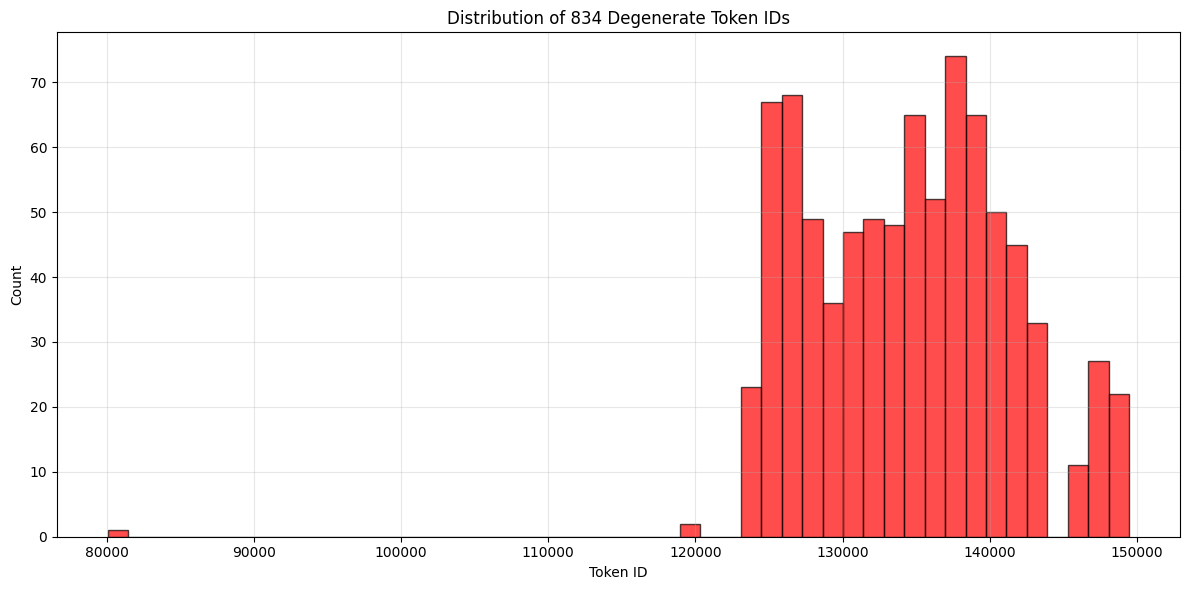


Histogram shows how degenerate tokens are distributed across vocabulary.


In [7]:
print("\n" + "="*60)
print("TOKEN ID DISTRIBUTION")
print("="*60)
print()

token_ids = all_degenerate_indices.cpu().numpy()

print(f"Token ID range:")
print(f"  Min: {token_ids.min():,}")
print(f"  Max: {token_ids.max():,}")
print(f"  Span: {token_ids.max() - token_ids.min():,}")
print()

# Check if they're clustered or scattered
print(f"Distribution analysis:")
print(f"  Median: {np.median(token_ids):.0f}")
print(f"  Mean: {np.mean(token_ids):.0f}")
print(f"  Std: {np.std(token_ids):.0f}")
print()

# Histogram
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
ax.hist(token_ids, bins=50, color='red', alpha=0.7, edgecolor='black')
ax.set_xlabel('Token ID')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of {len(token_ids):,} Degenerate Token IDs')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nHistogram shows how degenerate tokens are distributed across vocabulary.")

## Step 6: Check Embedding Identity

In [8]:
print("\n" + "="*60)
print("EMBEDDING ANALYSIS")
print("="*60)
print()

# Get embeddings for all degenerate tokens
degenerate_embeddings = gamma_prime[all_degenerate_indices]

# Compute pairwise distances
print("Computing pairwise distances within cluster...")
pairwise_dists = torch.cdist(degenerate_embeddings, degenerate_embeddings)

# Get upper triangle (excluding diagonal)
n_tokens = len(all_degenerate_indices)
upper_triangle = pairwise_dists[torch.triu(torch.ones(n_tokens, n_tokens), diagonal=1).bool()]

print(f"\nPairwise distance statistics (all pairs within cluster):")
print(f"  Min: {upper_triangle.min().item():.12f}")
print(f"  Max: {upper_triangle.max().item():.12f}")
print(f"  Mean: {upper_triangle.mean().item():.12f}")
print(f"  Median: {upper_triangle.median().item():.12f}")
print()

# Check how many pairs are exactly zero
exactly_zero = (upper_triangle == 0).sum().item()
total_pairs = len(upper_triangle)
print(f"Pairs with exactly zero distance: {exactly_zero:,} / {total_pairs:,} ({exactly_zero/total_pairs*100:.2f}%)")
print()

# Check if embeddings are truly identical
if upper_triangle.max().item() < 1e-6:
    print("CONCLUSION: All embeddings in cluster are IDENTICAL (within numerical precision).")
    print("This is true degeneracy - multiple token IDs map to the same vector.")
else:
    print("CONCLUSION: Embeddings are extremely close but not identical.")
    print("This is an ultra-dense cluster, not complete degeneracy.")


EMBEDDING ANALYSIS

Computing pairwise distances within cluster...

Pairwise distance statistics (all pairs within cluster):
  Min: 0.000000000000
  Max: 0.000000000000
  Mean: 0.000000000000
  Median: 0.000000000000

Pairs with exactly zero distance: 347,361 / 347,361 (100.00%)

CONCLUSION: All embeddings in cluster are IDENTICAL (within numerical precision).
This is true degeneracy - multiple token IDs map to the same vector.


## Step 7: Examine Embedding Vector

In [9]:
print("\n" + "="*60)
print("EMBEDDING VECTOR PROPERTIES")
print("="*60)
print()

# Properties of reference embedding
print(f"Reference token {REFERENCE_TOKEN_ID} embedding:")
print(f"  Norm: {reference_embedding.norm().item():.12f} gamma units")
print(f"  Min component: {reference_embedding.min().item():.12f}")
print(f"  Max component: {reference_embedding.max().item():.12f}")
print(f"  Mean component: {reference_embedding.mean().item():.12f}")
print(f"  Std component: {reference_embedding.std().item():.12f}")
print()

# Check for special structure
n_zeros = (torch.abs(reference_embedding) < 1e-10).sum().item()
print(f"Number of near-zero components: {n_zeros} / {d} ({n_zeros/d*100:.1f}%)")

if n_zeros > d * 0.9:
    print("\nWARNING: Embedding is extremely sparse! This may be uninitialized or corrupted.")
elif reference_embedding.norm().item() < 0.01:
    print("\nWARNING: Embedding is very close to origin! Possibly uninitialized.")


EMBEDDING VECTOR PROPERTIES

Reference token 149415 embedding:
  Norm: 0.166060775518 gamma units
  Min component: -0.025592491031
  Max component: 0.032932605594
  Mean component: -0.000032014319
  Std component: 0.003282549325

Number of near-zero components: 0 / 2560 (0.0%)


## Summary

Analysis of the degenerate embedding cluster at token 149415.

**Key findings:**
- Number of degenerate tokens: ???
- Distance range: ??? to ??? gamma units
- Character composition: Thai (??%), Unprintables (??%), CJK (??%), etc.
- Token ID distribution: clustered vs. scattered
- Embedding identity: true degeneracy or ultra-dense cluster?

This singularity represents a pathology in the unembedding matrix where multiple token IDs map to the same (or numerically indistinguishable) embedding vector. This is the vertical line visible at 164.5° longitude in the sky map, surrounded by the black stripe (forbidden region).